In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import math
import torch
import torch.optim as optim
import pandas as pd
from torch.utils import data

In [7]:
def rastrigin_function(x, n=2, A=1):
    return A * 2 + (x[0] ** 2 - A * torch.cos(x[0] * math.pi * 2)) + (x[1] ** 2 - A * torch.cos(x[1] * math.pi * 2))

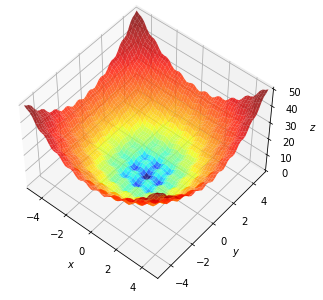

In [8]:
xmin, xmax, xstep = -5, 5, .2
ymin, ymax, ystep = -5, 5, .2
x, y = np.meshgrid(np.arange(xmin, xmax + xstep, xstep), np.arange(ymin, ymax + ystep, ystep))
z = rastrigin_function(torch.tensor([x, y])).numpy()

fig = plt.figure(figsize=(8, 5))
ax = plt.axes(projection='3d', elev=50, azim=-50)
ax.plot_surface(x, y, z, norm=LogNorm(), rstride=1, cstride=1, 
                edgecolor='none', alpha=.8, cmap=plt.cm.jet)
    
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

ax.set_xlim((xmin, xmax))
ax.set_ylim((ymin, ymax))

# plt.savefig("rastrigin.jpg")

plt.show()

In [9]:
# This is the SGD implementation
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opt = optim.SGD([p], lr=0.01)

path = np.empty((2,0))
path = np.append(path, p.data.numpy(), axis=1)

for i in range(100):
    opt.zero_grad()
    output = rastrigin_function(p)
    output.backward()
    opt.step()
    path = np.append(path, p.data.numpy(), axis=1)

In [10]:
# This is for SGD + momentum implementation 
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opt2 = optim.SGD([p], lr=0.01, momentum=0.9)
path_mom = np.empty((2,0))
path_mom = np.append(path_mom, p.data.numpy(), axis=1)

for i in range(100):
    opt2.zero_grad()
    output2 = rastrigin_function(p)
    output2.backward()
    opt2.step()
    path_mom = np.append(path_mom, p.data.numpy(), axis=1)

In [11]:
# This is for AdaGrad implementation 
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opt3 = optim.Adagrad([p], lr=0.01)
path_adagrad = np.empty((2,0))
path_adagrad = np.append(path_adagrad, p.data.numpy(), axis=1)

for i in range(100):
    opt3.zero_grad()
    output3 = rastrigin_function(p)
    output3.backward()
    opt3.step()
    path_adagrad = np.append(path_adagrad, p.data.numpy(), axis=1)

In [12]:
# This is for Adam implementation 
p = torch.tensor([[5.0],[5.0]], requires_grad=True)
opt4 = optim.Adam([p], lr=0.01)
path_adam = np.empty((2,0))
path_adam = np.append(path_adam, p.data.numpy(), axis=1)

for i in range(100):
    opt4.zero_grad()
    output4 = rastrigin_function(p)
    output4.backward()
    opt4.step()
    path_adam = np.append(path_adam, p.data.numpy(), axis=1)

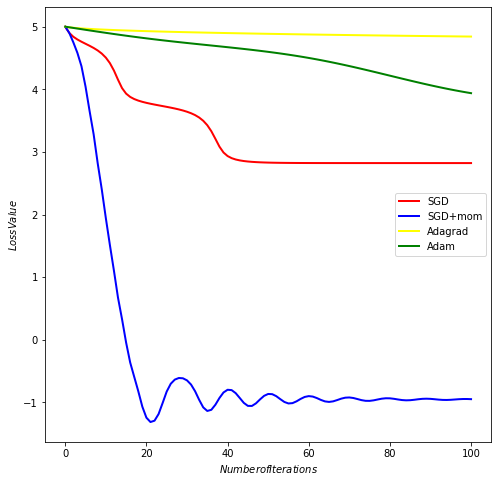

In [13]:
# Plot the optimisation values
fig, ax = plt.subplots(figsize=(8, 8))

arr = []
for i in range(101):
    arr.append(i)
    
ax.plot(arr, path[0], color='red', label='SGD', linewidth=2)
ax.plot(arr, path_mom[0], color='blue', label='SGD+mom', linewidth=2)
ax.plot(arr, path_adagrad[0], color='yellow', label='Adagrad', linewidth=2)
ax.plot(arr, path_adam[0], color='green', label='Adam', linewidth=2)


ax.legend()
ax.set_xlabel('$ Number of Iterations $')
ax.set_ylabel('$ Loss Value $')

plt.savefig("loss-plot.jpg")

## Part 2 of the Assignment

In [14]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases'+'/iris/iris.data', header=None)
df = df.sample(frac=1, random_state=0) #shuffle
df = df[df[4].isin(['Iris-virginica', 'Iris-versicolor'])]

# add label indices column
mapping = {k: v for v, k in enumerate(df[4].unique())} 
df[5] = (2 * df[4].map(mapping)) - 1 #labels in {−1,1}

# normalise data
alldata = torch.tensor(df.iloc[:, [0,1,2,3]].values, dtype=torch.float) 
alldata = (alldata - alldata.mean(dim=0)) / alldata.var(dim=0)

# create datasets
targets_tr = torch.tensor(df.iloc[:75, 5].values, dtype = torch.float) 
targets_va = torch.tensor(df.iloc[75:, 5].values, dtype = torch.float) 
data_tr = alldata[:75]
data_va = alldata[75:]

In [15]:
def hinge_loss(y_pred, y_true):
    lower_bound = torch.mean(0 - y_pred@y_true)
    upper_bound = torch.mean(1 - y_pred@y_true)
    return max(lower_bound, upper_bound)

def svm(x, w, b):
    h = (w*x).sum(1) + b
    return h

dataset = data.TensorDataset(data_tr, targets_tr)
data_loader = data.DataLoader(dataset, batch_size=25, shuffle=True)

In [29]:
scores_avg = 0
for i in range(500):
    w1 = torch.randn(1, 4, requires_grad=True)
    b1 = torch.randn(1, requires_grad=True)
    opt1 = optim.SGD([w1,b1], lr=0.01, weight_decay=0.0001)

    for epoch in range(100):
        for batch in data_loader:
            opt1.zero_grad()
            y_pred1 = svm(batch[0], w1, b1)
            loss1 = hinge_loss(y_pred1, batch[1])
            loss1.backward()
            opt1.step()
        
    # Computing validation scores
    pred1 = svm(data_va, w1, b1)
    scores1 = sum(pred1.detach().numpy() * targets_va.numpy()>=0)/len(data_va)
    scores_avg = scores_avg + scores1
    

print("Validation score for SVM with SGD is : ", scores_avg/500)

Validation score for SVM with SGD is :  0.9200000000000039


In [30]:
scores_avg2 = 0
for f in range(500):
    w2 = torch.randn(1, 4, requires_grad=True)
    b2 = torch.randn(1, requires_grad=True)
    opt5 = optim.Adam([w2,b2], lr= 0.01, weight_decay = 0.0001)

    for epoch in range(100):
        for batch in data_loader:
            opt5.zero_grad()
            y_pred2 = svm(batch[0], w2, b2)
            loss2 = hinge_loss(y_pred2, batch[1])
            loss2.backward()
            opt5.step()
        
    # Computing validation scores
    pred2 = svm(data_va, w2, b2)
    scores2 = sum(pred2.detach().numpy() * targets_va.numpy()>=0)/len(data_va)
    scores_avg2 = scores_avg2 + scores2
    
print("Validation score for SVM with Adam is : ", scores_avg2/500)

Validation score for SVM with Adam is :  0.8603999999999954
